<a href="https://colab.research.google.com/github/minthammock/dsc-mod-4-project-v2-1-onl01-dtsc-pt-041320/blob/master/colab_project_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision: Identifying Pnumonia From Chest X-Rays
### Michael Mahoney
##### Date: 12/11/2020

# Abstract
This notebook will attempt to create and analyze a neural network that is effective at identifying pneumonia in patient X-rays. The dataset used in this analysis was pulled from Kaggel, an open source data science competition website. We will build a convulutional neural network with two goals in mind. As a tool to be utilized in the medical industry the primary motivation and purpose for the model will be to identify sick patients. With this in mind, maximizing the positive case recall will be essentail for any model that's production worthy. 

The secondary, but also important, fuction of the model is to be accurate. Screening is significantly less useful if the underlying system is inundated with false-positive cases. While identifying patients with pneumonia is essentail, maximizing the model's recall score can't require abandoning the ability to distinguish which patients are healthy.
This notebook follows the guidelines of the CRISP-DM method of doing data-science. We will begin with a quick overview of the problem at hand, understand the challenges of classifying images, set a beseline and iteratively improve upon the baseline. The notebook will wrap up with a second benchmark, testing the arcitecture in this paper against a tuned VGG19 open source model imported for transfer learning. The notebook will conclude with an overal analysis of the final model's performace and relate it back to the industry. 

The model built in this paper was effective at classifying patients with pnumonia. The best iteration of the model had an overall accuracy of 93% and was correctly predicting 97% of all patients that had pneumonia and 88% of non-pneumonia patients. Based on this result there are the following recommendations:
* Integrate the model into the x-ray workflow to triage patients. Elevate the priority of high risk patients that the model has classified as having pneumonia.
* Use the model as a redundant system for radiologist diagnoses. It will improve overall patient health and provide additional insurance
* Collect hard to classify cases which radiologists and the model disagree on. This may lead to greater understanding of pneumonia detection. 

# Bussiness Understanding
Often times in the medical industry, images are a window into the complicated world of diagnoses. Anyone reading this is likely somewhat familiar with the standard workflow for diagnostic image processing. For completeness we will break this down into the emergancy and non-emergancy cases

1. Emergancy: 

    A patient comes into an emergancy room with respritory illness symptoms. They are sent for medical x-rays/ultasounds and the images are quickly reviewed by a radiologist while the patient is stabalized. The radiologist will then share any diagnosis with the patients emergancy room doctor and care will continue from there. 


2. Non-emergancy: 

    Anyone reading this paper is likely more familiar with this process. A patient comes to an medical imaging office with some respritory related issue (coughing, wheezing, difficulty breathing). They describe their symptoms and to a PA/MD and are taken for medical imaging. The x-rays/ultrasounds are generated on site but are then transmitted to a radiologist (contractor that is commonly not on site or on call at all times). In the mean time, the patient, if not showing any emergancy symptoms, is sent home with minor medication. Sometime later, The Radiologist reviews the images as they come and reports back with their diagnosis to the non-emergancy care team who then contacts the patient about further care. 

Where will our model have impact? Primarily, the model can function as an effective triage for non-emergancy patients. During the time in after the image is taken and before the radiologist is able to review them, patients are vulnerable to the positive conditions that worsen and become critical prior to the positive diagnosis. At this point, the patient is forced to go to the emergancy room and seek immediate medical attention. With the patient's health and finances on the line there are very tangible benefits to the patient by correctly identifying illness before the conditions worsens to emergancy conditions. Moreover, it corrects the issue at a non-emergancy level which is better financially for the medical institutions since emergancy care is much less likely to pay reliably (insurance and willingness to pay consideration.) A supplimental benefit could be during the emergancy phase of care. Models with high accuracy can be used as an additional check with radiologists beinging attention to tricky diagnoses. The implementation I can foresee in this case is generating a flag or an additional review if the doctor's diagnosis contradicts the model's prediction. 

At this point I think it's important to achknowledge the potential to expand this implemenation to other similar models tuned for other diseases (or potentially a large network with transfer learning). I would ask the reader to keep this in mind as we analyze our specific model because the potential to train similar models for other imaging tasks would be simple and desired. 

# Google Colab details:
If you would like to run this notebook in google colab, the following cells are for mounting and downloading the dataset into the working directory within colab. Mounting your personal drive to colab is easy but does require authentication. Run the cells and read the outputs for the directions. After your drive has been mounted please make sure you have 2.5 gigs available for the images in your colab storage.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# download the images for the notebooks markdown
import gdown
imageUrls = [
  {'url': "https://drive.google.com/uc?id=1Ry02_COjLT-smwdHC4DZVME9etoQZppD", 'name': 'third-model-training-metrics.png'},
  {'url': "https://drive.google.com/uc?id=17haQ-nl5uF2U3LtJY23LQJOGPJRBEedk",'name' : 'third-model-confusion-matrix.png'},
  {'url': "https://drive.google.com/uc?id=1Ii_XRKiV7SJnSCu7n8rPNTUNlVpux4r1",'name' : 'second-model-training-metrics.png'},
  {'url': "https://drive.google.com/uc?id=1SdeYh7P5xeefibiG_ffW4v_TdBfZjzd8",'name' : 'second-model-confusion-matrix.png'},
  {'url': "https://drive.google.com/uc?id=1U_Igskjkeo77ohEYD3kVOUZ1UEh6YhPE",'name' : 'pneumonia-image-1.jpg'},
  {'url': "https://drive.google.com/uc?id=1zRy4FEDoSM2zf_TyKV0kafM6WskB3wsh",'name' : 'normal-image1.jpg'},
  {'url': "https://drive.google.com/uc?id=1pes1jqx7k8l7D4g2MVYMX6nUPU_g3wwz",'name' : 'model-activations.png'},
  {'url': "https://drive.google.com/uc?id=1X75QlCiGsyY1xFEaZtRMhmQp4sFfU0_J",'name' : 'fourth-model-training-metrics.png'},
  {'url': "https://drive.google.com/uc?id=15k4j7wEB5VjTP8RlvDlhzAYNilgW96dN",'name' : 'fourth-model-confusion-matrix.png'},
  {'url': "https://drive.google.com/uc?id=1oRilPuugoTGDcwqVbgXRcL1RA1AtFqUc",'name' : 'baseline-model-training-metrics.png'}
]
for image in imageUrls:
  url = image['url']
  output = image['name']
  gdown.download(url, output, quiet=True)


In [ ]:
# download the dataset
url = "https://drive.google.com/uc?id=1Qog9htI2IKJQUxJCsVENEiiuR1hFV_i6"
output = 'repo.zip'
gdown.download(url, output, quiet=True)

In [ ]:
! unzip repo.zip;

# Package Dependancies
Open this section to view all package and sub dependancies used in this project. If you run this cell and get an import error please pip install the requirements before attempting to proceed. See google python and pip installation for more information.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics as skm
import sklearn.preprocessing as skp
from sklearn.utils import compute_class_weight
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import BalancedBatchGenerator
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import Sequential, Input, Model, layers, utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
import tensorflow.keras.metrics as km
from IPython.display import Image
from PIL import Image as pilImage
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import os
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from s

# Data Understanding
This project is all about x-rays. Loading in a couple different images we see the images are composed of various sizes and pixel brightnesses. There is existing class imbalance in this data of about 3:1 pneumonia to non-pneumonia. In total there are approximately 6000 images which we will be working with. Here are a couple Example images to get you oriented. The first image is the non-pneumonia case. The second is the pneumonia case. 


<img src = "https://drive.google.com/uc?id=1zRy4FEDoSM2zf_TyKV0kafM6WskB3wsh">
<img src = "https://drive.google.com/uc?id=1U_Igskjkeo77ohEYD3kVOUZ1UEh6YhPE">


# The Baseline Model
For the baseline model, this notebook will showcase the general method and explanations for how the neural network is being created. After this first round, several of the coding details will be left out or trimmed down. Rest assured the logic and decision making will still be expounded upon. 

Rather than using a truly dumb model to start off, we will build a very simpe perceptron with only one dense hidden layer. To keep the baseline model straight forward the dense layer will have 256 nodes that correspond to the dimension of the images it will be attempting to classify. There isn't any general sense that this methodology will yield better results, but it will suffice for a starting point for further iterations.

The hidden layer will utilize the "sigmoid" activation function which should be more appropriate for our scaled images, in which each pixel of information lies between the values of 0 and 1. 

The seaching parameters include stocastic gradient decent as the optimizing function, binary_crossentropy as the loss function and various metrics which we will use later on. Srocastic gradient decent (SGD) is the standard optimizer unless we have specific information which would drive us to other methods. As is true for the loss function. 
## Baseline Model Evaluation
### Evaluation Metrics
As pnumonia is a medical issue we will be using more metrics than usual when evaluating our models. This notebook will contain the following metrics when evaluating models. The Exception to this rule is the baseline which only features the first two metrics because the model is purposefully not optimized. 
* Loss
* Accuracy
### Accuracy
 For general interpretability, we include accuracy. Accuracy is the metric that best gives an answer to the question, "How does my model compare to an average guess." With this problem in particular, the data has a class imbalance so the question is more, "How does my model compare to a weighted average guess." This suggests that if we weighted a random guess to the proportions of the samples we've been given, we should expect around 74% accuracy on average. In the following two cells, the model is evaluated over the train and test sets, to produce the metrics we are interested in exploring further. 
 
 <img src = "https://drive.google.com/uc?id=1oRilPuugoTGDcwqVbgXRcL1RA1AtFqUc">
 
The graphs above could represent several issues with the model. For the image on the left, the loss function for the validation doesn't change on average over the 5 epochs, while the training loss continues downward roughly exponentially. The discrepancy is very likely do to overfitting of the training data. 

For the image on the right we see the training accuracy increasing logrithmicaly and the validation set ocillating around 75% accuracy. This is very likely do the simplicity of our model not being able to capture useful information about the images in the two dense layers in the baseline model. This is why we see the average accuracy very near what we would expect with a blind guess. The information the model picked up from the training set was particular enough to generalize to images it had never seen before.

For the following models, we will take a much deeper dive into model metrics (as well as indroduce several more). Considering this model is barely treding above a random guess, we will omit a more surgical analysis and move on to the next model. 

## Code To Create The Baseline Model

In [ ]:
trainPath = 'dsc-mod-4-project-v2-1-onl01-dtsc-pt-041320/data/chest_xray/train/'
testPath ='dsc-mod-4-project-v2-1-onl01-dtsc-pt-041320/data/chest_xray/test/'
 
# testPath = '/content/drive/MyDrive/Colab Notebooks/flatiron school/dsc-mod-4-project-v2-1-onl01-dtsc-pt-041320/data/chest_xray/test'
# trainPath = '/content/drive/MyDrive/Colab Notebooks/flatiron school/dsc-mod-4-project-v2-1-onl01-dtsc-pt-041320/data/chest_xray/train'

In [ ]:
# Create an image generator for the training set. We are spliting a validation set off of this training set
trainGenerator0 = ImageDataGenerator(
    rescale = 1./255
)
 
# Create an image generator for the training set. We are spliting a validation set off of this training set
testGenerator0 = ImageDataGenerator(
    validation_split=.3,
    rescale = 1./255
)

In [ ]:
# The flowed data from the directory for the training set. This will be fed directly into the neural networks
train0 = trainGenerator0.flow_from_directory(
    trainPath,  
    class_mode='binary',
    target_size=(256,256),
    batch_size = 5216,
    shuffle = True)
 
# The split off validation set. This is fed directly into the neural networks
val0 = testGenerator0.flow_from_directory(
    testPath, 
    class_mode='binary',
    target_size=(256,256),
    batch_size = 187,
    subset='validation',
    shuffle = True
)
 
# The flowed data from the directory for the testing set. This will be fed directly into the neural networks
test0 = testGenerator0.flow_from_directory(
    testPath, 
    class_mode='binary',
    target_size=(256,256),
    batch_size = 437,
    subset = 'training',
    shuffle = True
)

Found 5216 images belonging to 2 classes.
Found 187 images belonging to 2 classes.
Found 437 images belonging to 2 classes.


In [ ]:
trainImages, trainImageLabels = next(train0)
valImages, valImageLabels = next(val0)
testImages, testImageLabels = next(test0)

In [ ]:
weights = compute_class_weight(
    'balanced',
    classes=[0, 1],
    y = train0.labels
)
weights = {0:weights[0], 1:weights[1]}
weights

{0: 1.9448173005219984, 1: 0.6730322580645162}

In [ ]:
flatTrainImages = trainImages.reshape(5216,-1)
flatValImages = valImages.reshape(187 ,-1)
flatTestImages = testImages.reshape(437 ,-1)

# Save the shape of a flattened image in order to feed it into the model
inputShape = flatTrainImages.shape[1]

In [ ]:
# We will be using the keras functional API for building models. 

# define the input layer
baselineModelInputs = Input((inputShape,), name = 'input_layer')

# define the first layer
x1 = layers.Dense(128, activation = 'sigmoid')(baselineModelInputs)

# define the ourput layer
baselineModelOutput = layers.Dense(1, activation = 'sigmoid')(x1)

# Create an instance of the keras.Model class with the input and outputs above
baselineModel = Model(inputs=baselineModelInputs, outputs = baselineModelOutput, name = 'baseline_model')

#compile the model
baselineModel.compile(
    optimizer = 'sgd',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
# create the file path for where we want to save the resulting model
baseline_filepath = os.path.join('baseline_model')

In [ ]:
baselineModel.summary()

Model: "baseline_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 196608)]          0         
_________________________________________________________________
dense (Dense)                (None, 128)               25165952  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 25,166,081
Trainable params: 25,166,081
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# We fit the model, throwing in some basic parameters that will be tuned later. 
baselineHistory = baselineModel.fit(
    flatTrainImages,
    trainImageLabels,
    batch_size=32,
    epochs=100,
    validation_data=(flatValImages, valImageLabels),
    class_weight= weights,
#     callbacks=[baselineEarlyStop, baselineModelCheckpoint]  
)

Epoch 1/100
163/163 [==============================] - 2s 12ms/step - loss: 0.5763 - accuracy: 0.7088 - val_loss: 0.6773 - val_accuracy: 0.5829
Epoch 2/100
163/163 [==============================] - 2s 11ms/step - loss: 0.3658 - accuracy: 0.8457 - val_loss: 0.3687 - val_accuracy: 0.8021
Epoch 3/100
163/163 [==============================] - 2s 11ms/step - loss: 0.2881 - accuracy: 0.8811 - val_loss: 0.2740 - val_accuracy: 0.8663
Epoch 4/100
163/163 [==============================] - 2s 11ms/step - loss: 0.2286 - accuracy: 0.9024 - val_loss: 0.2309 - val_accuracy: 0.8824
Epoch 5/100
163/163 [==============================] - 2s 11ms/step - loss: 0.2112 - accuracy: 0.9156 - val_loss: 0.2269 - val_accuracy: 0.9198
Epoch 6/100
163/163 [==============================] - 2s 11ms/step - loss: 0.2138 - accuracy: 0.9101 - val_loss: 0.7614 - val_accuracy: 0.6952
Epoch 7/100
163/163 [==============================] - 2s 11ms/step - loss: 0.1728 - accuracy: 0.9279 - val_loss: 0.2825 - val_accuracy:

In [ ]:
dfBaseline = pd.DataFrame().from_dict(baselineHistory.history)
dfBaseline

,loss,accuracy,val_loss,val_accuracy
0,0.576326,0.708781,0.677273,0.582888
1,0.365830,0.845667,0.368742,0.802139
2,0.288074,0.881135,0.273962,0.866310
3,0.228575,0.902416,0.230886,0.882353
4,0.211185,0.915644,0.226919,0.919786
...,...,...,...,...
95,0.035975,0.985813,1.191390,0.721925
96,0.047436,0.982745,0.765383,0.770053
97,0.037772,0.986005,0.905660,0.764706
98,0.032627,0.988497,0.631139,0.828877


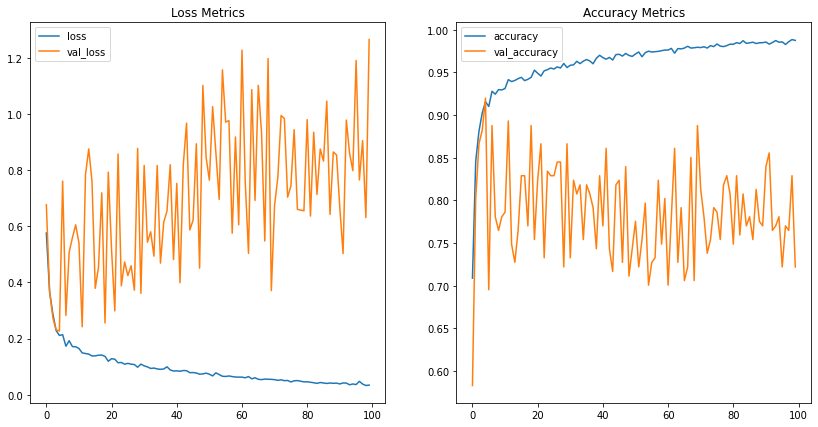

In [ ]:
fig, ((ax1, ax2)) = plt.subplots(nrows = 1,ncols = 2, figsize = (14,7))
dfBaseline.plot(y = ['loss', 'val_loss'],ax = ax1, title = 'Loss Metrics');
dfBaseline.plot(y = ['accuracy', 'val_accuracy'],ax = ax2, title = 'Accuracy Metrics');

### Load Pre-Saved Baseline Model

In [ ]:
# baselineModel = keras.models.load_model('./baseline_model/')

# Second Model: Advanced Connvulution Model
## Changes From Baseline
The simple dense layer model used as the baseline wasn't taylored to image classification. There are, however, several other layer types that are much more adept at picking up on the data structure of images. The second model will rely on convulutional and pooling layers. 

A true deep dive into the underlying workings of these layers is beyond the scope of this notebook but we will sum them up for convienence.
### Backgroud Information
#### Convulutional layers 
Convulutional layers are the life force of modern neural network image processing. Unlike dense layers which connect every node of a layer to every node of the next layer, convulutional layers only connect small portions of the input layers. This approach is modeled off the human ocular system and is a state of the art way for understanding high dimensional imformation that boils down to a smaller subset of features. Images are the connonical example of this, but there are also several other types of data that can be analyzed effectively in this way. Ultimately, the convulution layers serve as feature extractors. In almost all examples they are combined with traditiaonl dense layers which take the information filtered by the convulutional layers and create prediction based on the normal preceptron model.
#### Pooling Layers
Pooling layers are the balance to convulution layers. While not strictly necessary, pooling layers are often used to decrease the dimensionality of the data. Because dense are more or less required to lie on top of the convulution layers to preform the "thinking" part of the model, we run into a dimensionality problem when transitioning the data from the convulutional layers to the dense layers. Dense layers require 1-dimensional input where as convulutional layers are capable of analyzing and outputing multi-dimensional data (2-dimensions in this case). In order to create this transition we must flatten the 2-dimensional data into 1 dimension which explodes the number of required node connections for the first dense layer. A 256 X 256 pixel image to transition to a dense layer of 20 nodes requires 128,000 connections per filter used in the preceeding convulutional layer. This will quickly get out of hand. The solution is pooling layers. Pooling layers use summary statistics to combine areas of the convulutional layers whereby effectively reducing the output data's dimensionality while preserving most of the information from the inputs. While, reducing the number of features likely means a reduced accuracy rate, the output will still retain enough features to catagorize images with incredible accuracy (this shouldn't be too surprising if you think about how quickly you can recognize objects from your periferal vision.)
## Building the second model
If you want to see the code involved with creating and fitting the convulutional model please open the code below. We will cover the methodology in narrative here. Because we want to take advantage of the Imagedatagenterator class' ability to augment data the first thing we are going to do is create new generator objects. The training generator will include a number of augmentation parameters that were determined through trial and error. 
* A short comment on the parameters: Augmentation was extremely beneficial to the convulutional models preformace. The actual numbers used reflect a moderate amount of augmentation. Ultimately, no reflections or rotations were utilized as they appeared to have a strictly negative impact on model preformace. One possible reason for this couls be the standard directionality of the x-rays themselves which were all oriented in the same manner. Ultimately, if there's no standardization in the image uploading process then rotational and reflection augmentations may have a more positive impact. But, with this specific dataset, they were not considered. 

There are some specific data manipulations that are implemented in order to better utalize colab resources and avoid having to access the directory system for each batch. If you wish to inspect the cod used to create the second model you can expand the following cells and go wild.

### Model Layers
The second model is composed of the following architecture. 
* [Insert layers list for convulutional network]
* [Insert layers for dense network]

Many of these decisions were based on some initial experimentation and third party research. The specific design was based on designs featured from two papers. One paper is titled "FRD-CNN: Object detection based on small-scale convolutional neural networks and feature reuse" and "Efficient Deep Network Architectures for Fast Chest X-Ray Tuberculosis Screening and Visualization" both of which are articles featured in the journal "scientific reports"

The general idea for the network architecture is to have two convulution layers followed by a pooling a layer. This pattern is repeated between 5 to 10 times and then the resulting filters are funneled into the dense layers and finally into the binary decision layer. The two literature resources have additional features that are specifically designed for image segmentation. I left these components out of my architecture. In addition, I added additional batch normalization layers in order to further decrease the probability of overfitting. 

The funnel chose for connecting my convulutional and dense layers was a global average pooling layer. This is a specific type of pooling layer than creates a single value from the each of the filters being passed to it. The general idea of a convulutional layer is to extract features from the initial images. The global average pooling layer then represents each of these features with a single values that hopefully the dense layers can use to learn. The reason for using this particular type of pooling layer is to avoid overfitting in the dense layers. Images have so much information from the number of pixels that dense layers have a tendency to memorize the training images. This is a phenomenon in which the neural network will have incredible accuracy on the training images but struggle to generalize to a testing set. 

For a full list of model parameters please see the code sections. In general, relu activation was used for the convulutional layers and orthogonol kernals were used to initialize the kernal state.  

### Model Fitting
This image shows the training metric progression for fitting the model.
<img src = "https://drive.google.com/uc?id=1Ii_XRKiV7SJnSCu7n8rPNTUNlVpux4r1">

## Second Model Evaluation
We begin with a visual of the confusion matrix, often a staple summary of a model's preformance. 
<img src = "https://drive.google.com/uc?id=1SdeYh7P5xeefibiG_ffW4v_TdBfZjzd8">

### General Preformace

The second model has performed incredibly well in comparison to the baseline. The training curves jitter as the model attempts to find the underlying features of the data and becomes incredibly smooth as it settles on a final weight configuration. The right end of the curve suggest the model isn't massivly overfitting or failing to converge which is a good position to be in for increased generalization. 

### Accuracy

Our model has landed on 93% overall accuracy during the best training iteration, a massive improvement from the baseline and overall an impressive achievement given the limited number of images in the dataset. 

### Pneumonia Recall

The recall on the positive case was 97%. This is almost optimal given the task is medical diagnosis and catching the positive case is more important than strict accuracy. 

### Non-Pneumonia Recall

Recall preformace on the negative class was 87%. Lower than the positive case but if the choice was to increase the negative case accuracy at the expense of the positive case accuracy then the model would be less effective overall even if there was a slight increase in accuracy overall. 

## Code To Create The Second Model

In [ ]:
# We don't do any image rotations or reflections because they tended to yield worse results
# This isn't likely to reduce the model ability to generalize because images should be uploaded
# in a standard way
trainGenerator = ImageDataGenerator(
    width_shift_range=0.3,
    height_shift_range=0.3, 
    zoom_range=0.15,
    )

# no augments on the test generator
testGenerator = ImageDataGenerator()


In [ ]:
# The flowed data from the top of the notebook. This will be fed directly into the neural networks
 
train = trainGenerator.flow(
    trainImages,
    y = trainImageLabels, 
    shuffle = False,
    batch_size = 64,
)
# The split off validation set. This is fed directly into the neural networks
val = testGenerator.flow(
    valImages,
    y = valImageLabels, 
    shuffle = False,
    batch_size = 64,
 
)
 
# The flowed data from the top of the notebook. This will be fed directly into the neural networks
test = testGenerator.flow(
    testImages,
    y = testImageLabels, 
    shuffle = False,
    batch_size = 64,
 
)

In [ ]:
def create_model_visuals(model, trainGenerator, valGenerator, testGenerator, batch_size, epochs, class_weight, train = True,kwargs = {}):
  params = locals()
  def confustion_matrix(y, y_hat, normalize = 'true'):
    fig, ax = plt.subplots(1,1,figsize = (7,6))
    matrix = skm.confusion_matrix(y, y_hat, normalize=normalize,)
    sns.heatmap(matrix, cmap = 'Blues', annot=True, ax = ax)
    ax.set(
      title = 'Confustion Matrix',
      xlabel = 'Predicted Label',
      ylabel = 'True Label'
    )
  if train == True:
    modelHistory = model.fit(
        trainGenerator,
        batch_size=batch_size,
        epochs=epochs,
        class_weight = class_weight,
        **kwargs)
    model.evaluate(testGenerator)
    dfModel = pd.DataFrame().from_dict(modelHistory.history)
    fig, ((ax1,ax2),(ax3,ax4),(ax5, ax6)) = plt.subplots(nrows = 3,ncols = 2, figsize = (18,7))
    dfModel.plot(y = ['loss', 'val_loss'],ax = ax1, title = 'Loss Metrics', xlabel = 'Training Generation', ylabel = 'Loss score');
    dfModel.plot(y = ['accuracy', 'val_accuracy'],ax = ax2, title = 'Accuracy',xlabel = 'Training Generation', ylabel = 'Accuracy Percentage');
    dfModel.plot(y = ['auc', 'val_auc'],ax = ax3, title = 'Area Under The Curve',xlabel = 'Training Generation', ylabel = 'Area Under The Curve');
    dfModel.plot(y = ['square_hinge', 'val_square_hinge'],ax = ax4, title = 'Square Hinge',xlabel = 'Training Generation', ylabel = 'Square Hinge');
    dfModel.plot(y = ['val_true_positives'],ax = ax5, title = 'Val True Positives',xlabel = 'Training Generation', ylabel = 'Number of True Positives');
    dfModel.plot(y = [ 'val_true_negatives'],ax = ax6, title = 'Val True Negatives',xlabel = 'Training Generation', ylabel = 'Number of True Negatives');
    plt.tight_layout()
    plt.show()
     
  else:
    dfModel = None
 
  y_test_hat = np.where(model.predict(testGenerator) > .5, 1,0).flatten()
  y_test = testGenerator.y
  confustion_matrix(y_test, y_test_hat)
  dfTest = pd.DataFrame.from_dict(skm.classification_report(y_test, y_test_hat, output_dict=True))
  display(dfTest)
 
  return dfModel,params

In [ ]:
def scale_weight(num): 
  weights = compute_class_weight(
    'balanced',
    classes=[0, 1],
    y = trainImageLabels)
  weights = {0:weights[0]*num, 1:weights[1]/num}
  return weights

In [ ]:
secondModel = Sequential()
secondModel.add(
    layers.Conv2D(
      16,
      strides = 1,
      kernel_size = (3,3),
      activation = 'relu', 
      padding = 'same', 
      kernel_initializer=keras.initializers.Orthogonal(), 
      input_shape = (256,256,3)
      )
    )
secondModel.add(
    layers.Conv2D(
      16,
      strides = 1,
      kernel_size = (3,3),
      activation = 'relu', 
      padding = 'same', 
      )
    )
 
secondModel.add(layers.BatchNormalization())
 
secondModel.add(layers.MaxPooling2D(2))
 
secondModel.add(
    layers.Conv2D(
      32,
      strides = 1,
      kernel_size = (3,3),
      activation = 'relu', 
      padding = 'same', 
      kernel_initializer=keras.initializers.Orthogonal(), 
      )
    )
 
secondModel.add(
    layers.Conv2D(
      32,
      strides = 1,
      kernel_size = (3,3),
      activation = 'relu', 
      padding = 'same', 
      )
    )
 
secondModel.add(layers.BatchNormalization())
 
secondModel.add(layers.MaxPooling2D(2))
 
secondModel.add(
    layers.Conv2D(
      64,
      strides = 1,
      kernel_size = (3,3),
      activation = 'relu', 
      padding = 'same', 
      kernel_initializer=keras.initializers.Orthogonal(), 
      )
    )
 
secondModel.add(
    layers.Conv2D(
      64,
      strides = 1,
      kernel_size = (3,3),
      activation = 'relu', 
      padding = 'same', 
      )
    )
 
secondModel.add(layers.BatchNormalization())
 
 
secondModel.add(layers.MaxPooling2D(2))
 
 
secondModel.add(
    layers.Conv2D(
      128,
      strides = 1,
      kernel_size = (3,3),
      activation = 'relu', 
      padding = 'same', 
      kernel_initializer=keras.initializers.Orthogonal(), 
      )
    )
 
secondModel.add(
    layers.Conv2D(
      128,
      strides = 1,
      kernel_size = (3,3),
      activation = 'relu', 
      padding = 'same', 
      )
    )
 
secondModel.add(layers.BatchNormalization())
 
 
secondModel.add(layers.MaxPooling2D(2))
 
secondModel.add(
    layers.Conv2D(
      256,
      strides = 1,
      kernel_size = (3,3),
      activation = 'relu', 
      padding = 'same', 
      kernel_initializer=keras.initializers.Orthogonal(), 
      )
    )
 
secondModel.add(
    layers.Conv2D(
      256,
      strides = 1,
      kernel_size = (3,3),
      activation = 'relu', 
      padding = 'same', 
      )
    )
 
secondModel.add(layers.BatchNormalization())
 
secondModel.add(layers.MaxPooling2D(2))
 
secondModel.add(
    layers.Conv2D(
      512,
      strides = 1,
      kernel_size = (3,3),
      activation = 'relu', 
      padding = 'same', 
      kernel_initializer=keras.initializers.Orthogonal(), 
      )
    )
 
secondModel.add(
    layers.Conv2D(
      512,
      strides = 1,
      kernel_size = (3,3),
      activation = 'relu', 
      padding = 'same', 
      )
    )
 
secondModel.add(layers.BatchNormalization())

 
secondModel.add(layers.GlobalAveragePooling2D())
 
 
secondModel.add(layers.Dense(
    128, 
    kernel_initializer=keras.initializers.Orthogonal(),
    activity_regularizer = keras.regularizers.L2(.02),
    )
)
 
secondModel.add(layers.LeakyReLU())
 
secondModel.add(layers.BatchNormalization())
 
secondModel.add(layers.Dense(
    6,
    activation= 'tanh',
    kernel_initializer = keras.initializers.Orthogonal())
)
 
secondModel.add(layers.BatchNormalization())
 
 
secondModel.add(layers.Dense(
    6, 
    activation= 'tanh',
    kernel_initializer = keras.initializers.Orthogonal(),
    ))
 
secondModel.add(layers.Dense(1, activation = 'sigmoid'))
 
 
secondModel.compile(
    optimizer = keras.optimizers.RMSprop(
        learning_rate=.001,
        # momentum = .1
        ),
    loss = keras.losses.BinaryCrossentropy(),
    metrics = [
      keras.metrics.BinaryAccuracy(name = 'accuracy'),
      keras.metrics.AUC(name = 'auc'),
      keras.metrics.SquaredHinge(name = 'square_hinge'),
      keras.metrics.TruePositives(name='true_positives'), 
      keras.metrics.TrueNegatives(name = 'true_negatives')]
)
secondModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 16)      2320      
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 32)      1

Epoch 1/150
82/82 [==============================] - ETA: 0s - loss: 0.5391 - accuracy: 0.7287 - auc: 0.8735 - square_hinge: 0.5638 - true_positives: 2577.0000 - true_negatives: 1224.0000WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: second_model/assets
82/82 [==============================] - 72s 876ms/step - loss: 0.5391 - accuracy: 0.7287 - auc: 0.8735 - square_hinge: 0.5638 - true_positives: 2577.0000 - true_negatives: 1224.0000 - val_loss: 9.1411 - val_accuracy: 0.3743 - val_auc: 0.5000 - val_square_hinge: 0.9425 - val_true_posit

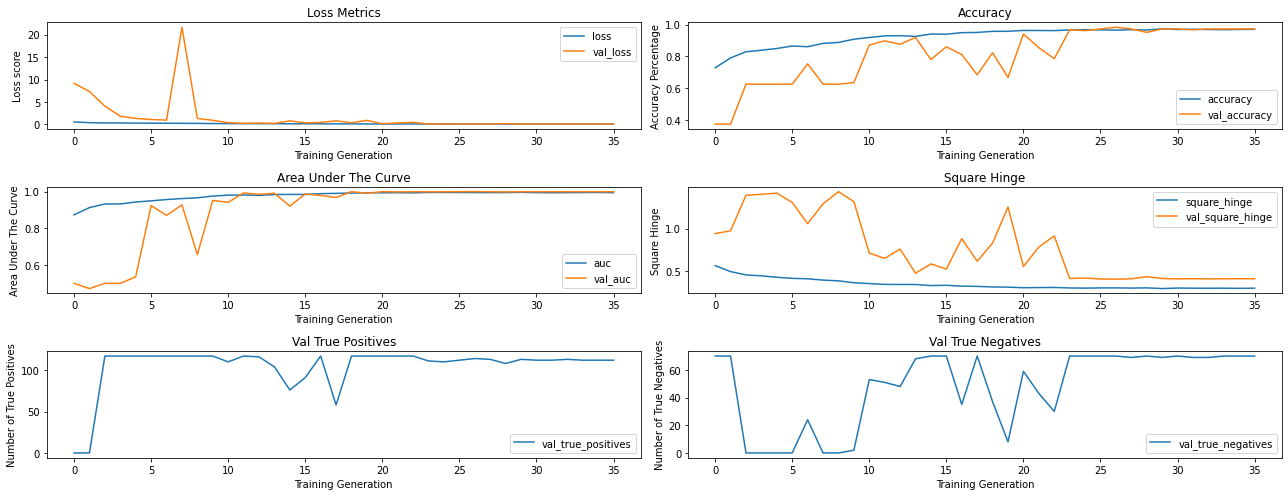

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.897260,0.886598,0.89016,0.891929,0.890599
recall,0.798780,0.945055,0.89016,0.871918,0.890160
f1-score,0.845161,0.914894,0.89016,0.880027,0.888724
support,164.000000,273.000000,0.89016,437.000000,437.000000


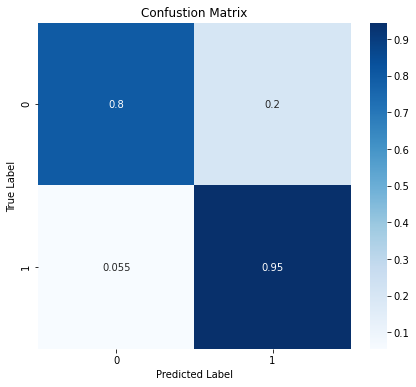

In [ ]:
# we define the filepath where any results will be saved
secondModel_filepath = os.path.join('second_model')

# the Callbacks for keras.Model.fit() method. See Keras documentation for more info.
secondModelEarlyStop = EarlyStopping(patience= 9, mode = 'auto', restore_best_weights=False, monitor='val_loss')
secondModelCheckpoint = ModelCheckpoint(secondModel_filepath,save_best_only=True, monitor='val_loss')
secondModelLRAdjust = ReduceLROnPlateau(monitor = 'val_loss', factor = .5, patience=2, min_delta=.00000000001)

# This cell runs the fitting 
secondModelHistory,params = create_model_visuals(
    model = secondModel, 
    trainGenerator=train, 
    valGenerator=val, 
    testGenerator=test, 
    epochs = 150, 
    batch_size=64,
    class_weight = scale_weight(1.5),
    kwargs = {
        'validation_data': (valImages, valImageLabels),
        'callbacks':[secondModelCheckpoint, secondModelEarlyStop, secondModelLRAdjust]})

In [ ]:
# save the training information to a dataframe for future visualization.
secondModelHistory.to_csv('secondModel-train-info.csv')

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/flatiron school/second_model_non_checkpoint/assets
INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/flatiron school/second_model_checkpoint/assets


,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.908397,0.852941,0.869565,0.880669,0.873753
recall,0.725610,0.956044,0.869565,0.840827,0.869565
f1-score,0.806780,0.901554,0.869565,0.854167,0.865987
support,164.000000,273.000000,0.869565,437.000000,437.000000


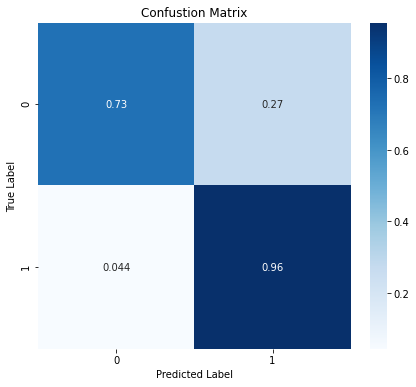

In [ ]:
# The previous fitting method saves the model with the least validation loss score, but also prints out
# the model when the early stopping callback stops the fitting. Because of this we get two models from the previous cell

# save the model spit out by the fit method
keras.models.save_model(secondModel, 'second_model_non_checkpoint/')
#load the model saved by the checkpoint callback
secondModel = keras.models.load_model('second_model/')
#show the eval metrics for the check pointed model
keras.models.save_model(secondModel, 'second_model_checkpoint/')

secondModel = keras.models.load_model('second_model_checkpoint/')
secondModelHistory,params = create_model_visuals(
    model = secondModel, 
    trainGenerator=train, 
    valGenerator=val, 
    testGenerator=test, 
    epochs = 100, 
    batch_size=64,
    class_weight = scale_weight(1),
    train = False,
    kwargs = {
        'validation_data': (valImages, valImageLabels),
        'callbacks':[secondModelCheckpoint, secondModelEarlyStop]})

# Third Model: Undersampling The Majority Class
## Changes From The Second Model
In building the second model, class imbalance was a key issue. The first step in refining the model is to determine to what extent this imbalance is affecting the overal performace. The third model is comprised of the same architecture as the second model. The input data is an undersampled version of the original, such that we've randomly selected 1341 pnuemonia images to match the 1341 normal images. In addition, the following model has slightly different callbacks and class weights to compensate for this shift in class proportions.

## Building Third Model

### Data Preperation
### Model Architecture
### Model Fitting
This image shows the training metric progression for fitting the model.

<img src = "https://drive.google.com/uc?id=1Ry02_COjLT-smwdHC4DZVME9etoQZppD">

## Third Model Evaluation
### General Performace
The third model had the following confusion matrix

<img src = "https://drive.google.com/uc?id=17haQ-nl5uF2U3LtJY23LQJOGPJRBEedk">

The model preformed substantially better than the baseline case. The training curves for this model are more dubious than the second model's. The first ten or so epochs roughly mirror the learning from the preievous case but the validation set loss then rapidly decreases below the training set loss. This continues until the end of the training. Oddly, the training set accuracy only managed to obtain 82% accuracy before the earlystopping callback ended the '.fit' method. This is proof that the model wasn't simply memorizing the training images - likely thanks to the data augmentation. What is more likely here is that reducing the dataset so significantly by undersampling may have limited the total amount of underanding the model could glean from the data. The suprieror validation metics lend credence to this theory as the images in the validation set were not augmented and easier to predict. One thing of note for the third model is the close proximity between the testing and training metrics. One can infer the reason is due to the learned patterns in the training set being generalizable.  

In general the model could still find use in classifying the problem at hand given that it is significantly better than the baseline. However, the second model is proof that much more capable models exist and should be utilized over this one. 

### Accuracy
The model's overall accuracy was 81%.

### Pneumonia Recall

The recall on the positive case was 90%.  

### Non-Pneumonia Recall

The recall on the negative case was 66%.  

### Comparison: Third Model vs Second Model

Not much brain power needs to be put into this comparison. The original motivation for the third model was to see if the class imbalace in the data was causing decreased accuracy. It seems that by undersampling, whereby decreasing the total number of images the model saw during training, there was a substantial drop in performace. This is likely the result of decreasing the total information the model was able to learn on. Specifically, given the observed numbers indicate the model was essentially the same when classifying the negative class, the extra images in the positive class that were discarded likely aided in classifying the positive case, and didn't inhibit identifying the negative case. This speaks to the nature of the classification problem, such that more data will likely leed to better accuracy and precision for both the positive and negative cases. 

## Code To Create The Third Model

In [ ]:
# This cell preforms the undersampling

# We begin by sorting the training data by class
x_p = trainImages[trainImageLabels == 1]
x_n = trainImages[trainImageLabels == 0]

# we get the total length of the minority class. This will determine how many majority class data points we pull
num = x_n.shape[0]

# make the number of data points into a nparray. 
index_list = np.arange(0,num)

# Take a random subsample of the same number of the minority class
sliceIndecies = np.random.choice(index_list, (num,), replace = False)
x_p_Resampled = trainImages[sliceIndecies]
y_p_resampled = np.array([1 for i in range(num)])
y_n_resampled = np.array([0 for i in range(num)])

# combine the resampled images with their proper labels
train_images_resampled = np.vstack((x_p_Resampled,x_n))
train_labels_resampled = np.hstack((y_p_resampled,y_n_resampled))

# shuffle the images around so the model doesn't pick up on the label ordering. 
index = np.random.permutation(train_images_resampled.shape[0])
train_images_resampled, train_labels_resampled = train_images_resampled[index], train_labels_resampled[index]

In [ ]:
# Create image generators and fit to the new under sampled training data

trainGenerator = ImageDataGenerator(
    rotation_range=45, 
    width_shift_range=0.1,
    height_shift_range=0.1, 
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
    )
trainGenerator.fit(train_images_resampled)

# we re-run the train generator for consisstancy
testGenerator = ImageDataGenerator(
)
testGenerator.fit(testImages)

In [ ]:
# Again we use the .flow method to use all our images at once rather than waiting for the steam from directory
 
train = trainGenerator.flow(
    train_images_resampled,
    y = train_labels_resampled, 
    shuffle = False,
    batch_size = 64,)

# The split off validation set. This is fed directly into the neural networks
val = testGenerator.flow(
    valImages,
    y = valImageLabels, 
    shuffle = False,
    batch_size = 64,)
 
# Again we use the .flow method to use all our images at once rather than waiting for the steam from directory
test = testGenerator.flow(
    testImages,
    y = testImageLabels, 
    shuffle = False,
    batch_size = 64,)

In [ ]:
thirdModel = Sequential()
thirdModel.add(
    layers.Conv2D(
      16,
      strides = 1,
      kernel_size = (3,3),
      activation = 'relu', 
      padding = 'same', 
      kernel_initializer=keras.initializers.Orthogonal(), 
      input_shape = (256,256,3)
      )
    )
thirdModel.add(
    layers.Conv2D(
      16,
      strides = 1,
      kernel_size = (3,3),
      activation = 'relu', 
      padding = 'same', 
      )
    )
 
thirdModel.add(layers.BatchNormalization())
 
thirdModel.add(layers.MaxPooling2D(2))
 
thirdModel.add(
    layers.Conv2D(
      32,
      strides = 1,
      kernel_size = (3,3),
      activation = 'relu', 
      padding = 'same', 
      kernel_initializer=keras.initializers.Orthogonal(), 
      )
    )
 
thirdModel.add(
    layers.Conv2D(
      32,
      strides = 1,
      kernel_size = (3,3),
      activation = 'relu', 
      padding = 'same', 
      )
    )
 
thirdModel.add(layers.BatchNormalization())
 
thirdModel.add(layers.MaxPooling2D(2))
 
thirdModel.add(
    layers.Conv2D(
      48,
      strides = 1,
      kernel_size = (3,3),
      activation = 'relu', 
      padding = 'same', 
      kernel_initializer=keras.initializers.Orthogonal(), 
      )
    )
 
thirdModel.add(
    layers.Conv2D(
      48,
      strides = 1,
      kernel_size = (3,3),
      activation = 'relu', 
      padding = 'same', 
      )
    )
 
thirdModel.add(layers.BatchNormalization())
 
 
thirdModel.add(layers.MaxPooling2D(2))
 

thirdModel.add(
    layers.Conv2D(
      64,
      strides = 1,
      kernel_size = (3,3),
      activation = 'relu', 
      padding = 'same', 
      kernel_initializer=keras.initializers.Orthogonal(), 
      )
    )
 
thirdModel.add(
    layers.Conv2D(
      64,
      strides = 1,
      kernel_size = (3,3),
      activation = 'relu', 
      padding = 'same', 
      )
    )
 
thirdModel.add(layers.BatchNormalization())
 
 
thirdModel.add(layers.MaxPooling2D(2))

thirdModel.add(
    layers.Conv2D(
      128,
      strides = 1,
      kernel_size = (3,3),
      activation = 'relu', 
      padding = 'same', 
      kernel_initializer=keras.initializers.Orthogonal(), 
      )
    )
 
thirdModel.add(
    layers.Conv2D(
      128,
      strides = 1,
      kernel_size = (3,3),
      activation = 'relu', 
      padding = 'same', 
      )
    )

thirdModel.add(layers.BatchNormalization())


thirdModel.add(layers.GlobalAveragePooling2D())
 
 
thirdModel.add(layers.Dense(
    128, 
    kernel_initializer=keras.initializers.Orthogonal(),
    # activation = 'relu'
    # activity_regularizer = keras.regularizers.L2(.05),
    )
)

# thirdModel.add(layers.LeakyReLU())
 
thirdModel.add(layers.Dropout(.2))
 
thirdModel.add(layers.Dense(
    16,
    # activity_regularizer = keras.regularizers.L2(.02),
    activation = 'tanh',
    kernel_initializer = keras.initializers.Orthogonal())
)
 
# thirdModel.add(layers.LeakyReLU())

 
# thirdModel.add(layers.Dense(
#     4, 
#     activation= 'tanh',
#     kernel_initializer = keras.initializers.Orthogonal(),
#     ))
 
thirdModel.add(layers.Dense(1, activation = 'sigmoid'))
 
 
thirdModel.compile(
    optimizer = keras.optimizers.RMSprop(
        learning_rate=.001,
        rho = .8,),
    loss = keras.losses.BinaryCrossentropy(),
    # loss = tfa.losses.SigmoidFocalCrossEntropy(alpha=.26, gamma=1.1),
    metrics = [keras.metrics.BinaryAccuracy(name = 'accuracy'),keras.metrics.TruePositives(name='true_positives'), keras.metrics.TrueNegatives(name = 'true_negatives')]
)
thirdModel.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_70 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 256, 256, 16)      2320      
_________________________________________________________________
batch_normalization_35 (Batc (None, 256, 256, 16)      64        
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_36 (Batc (None, 128, 128, 32)     

In [ ]:
# This is the same callback system as the second model

thirdModel_filepath = os.path.join('third_model')
thirdModelEarlyStop = EarlyStopping(patience=10, mode = 'auto', restore_best_weights=False, monitor='val_loss')
thirdModelCheckpoint = ModelCheckpoint(thirdModel_filepath,save_best_only=True, monitor='val_loss')
thirdModelLRAdjust = ReduceLROnPlateau(monitor = 'val_loss', factor = .5, patience=2, min_delta=.00000000001)

Epoch 1/100
42/42 [==============================] - 40s 955ms/step - loss: 0.5296 - accuracy: 0.7535 - true_positives: 849.0000 - true_negatives: 1172.0000 - val_loss: 0.6609 - val_accuracy: 0.5936 - val_true_positives: 109.0000 - val_true_negatives: 2.0000
Epoch 2/100
42/42 [==============================] - 37s 883ms/step - loss: 0.4773 - accuracy: 0.7841 - true_positives: 909.0000 - true_negatives: 1194.0000 - val_loss: 1.0738 - val_accuracy: 0.6257 - val_true_positives: 117.0000 - val_true_negatives: 0.0000e+00
Epoch 3/100
42/42 [==============================] - 40s 964ms/step - loss: 0.4730 - accuracy: 0.7875 - true_positives: 909.0000 - true_negatives: 1203.0000 - val_loss: 0.4959 - val_accuracy: 0.7273 - val_true_positives: 117.0000 - val_true_negatives: 19.0000
Epoch 4/100
42/42 [==============================] - 38s 897ms/step - loss: 0.4679 - accuracy: 0.7886 - true_positives: 886.0000 - true_negatives: 1229.0000 - val_loss: 1.3841 - val_accuracy: 0.3743 - val_true_positive

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.733728,0.850746,0.805492,0.792237,0.806831
recall,0.756098,0.835165,0.805492,0.795631,0.805492
f1-score,0.744745,0.842884,0.805492,0.793814,0.806053
support,164.000000,273.000000,0.805492,437.000000,437.000000


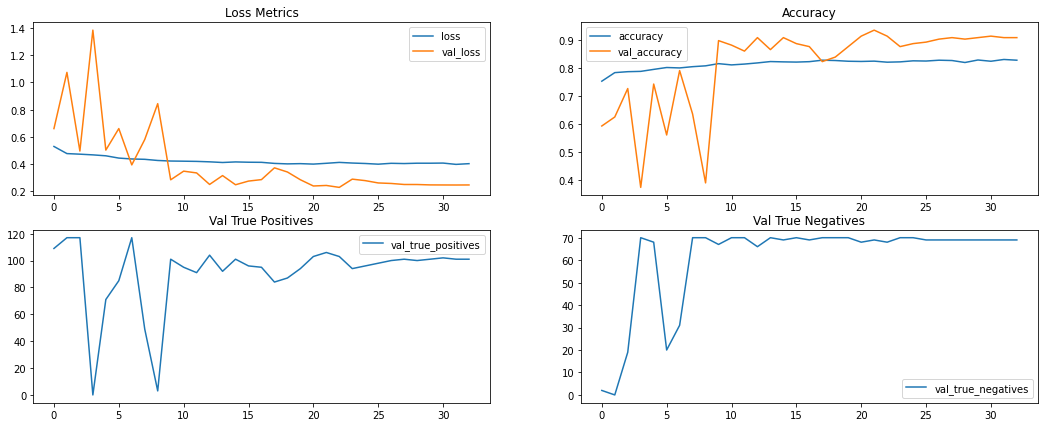

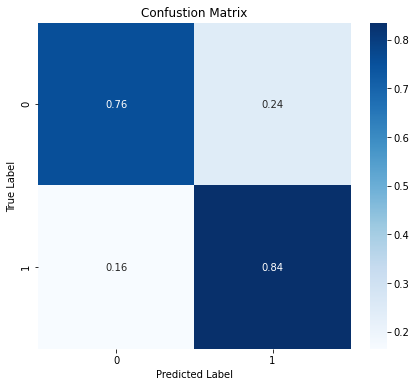

In [ ]:
thirdModelHistory,params = create_model_visuals(
    model = thirdModel, 
    trainGenerator=train, 
    valGenerator=val, 
    testGenerator=test, 
    epochs = 100, 
    batch_size=64,
    class_weight = {0:1, 1:1},
    kwargs = {
        'validation_data': (valImages, valImageLabels),
        'callbacks':[thirdModelCheckpoint, thirdModelEarlyStop, thirdModelLRAdjust]})

In [ ]:
keras.models.save_model(thirdModel, 'drive/MyDrive/Colab Notebooks/flatiron school/third_model_non_checkpoint/')
thirdModel = keras.models.load_model('third_model/')
keras.models.save_model(thirdModel, 'drive/MyDrive/Colab Notebooks/flatiron school/third_model_checkpoint/')

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/flatiron school/third_model_non_checkpoint/assets


,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.795620,0.816667,0.810069,0.806144,0.808768
recall,0.664634,0.897436,0.810069,0.781035,0.810069
f1-score,0.724252,0.855148,0.810069,0.789700,0.806025
support,164.000000,273.000000,0.810069,437.000000,437.000000


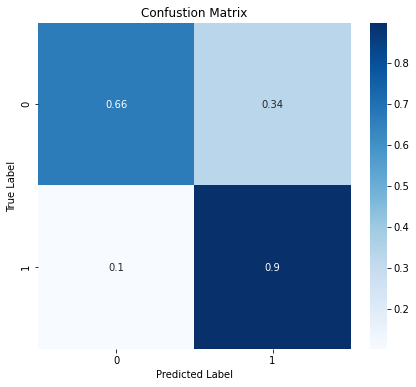

In [ ]:
thirdModelHistory,params = create_model_visuals(
    model = thirdModel, 
    trainGenerator=train, 
    valGenerator=val, 
    testGenerator=test, 
    epochs = 100, 
    batch_size=64,
    class_weight = scale_weight(1),
    train = False,
    kwargs = {
        'validation_data': (valImages, valImageLabels),
        'callbacks':[thirdModelCheckpoint, thirdModelEarlyStop]})

# Fourth Model: Oversampling The Minority Class
## Changes From The Third Model
The fourth model is going to attempt an oversampling of the minority class. In terms of the model architecture, some small tweeks to the class weights will be made but no other hyper-parameters will be changed. 
## Building Fourth Model
### Data Preperation
This time around the name of the game is generating "new" images of the minority class that can be used to supplement. In order to do that we will be placing the existing minority class images into a new Imagedatagenerator object and using augmentation in order to artificially create new images that will then be trained on. The hope of this process is to increase the model's exposure to more x-rays of healthy lungs. Currently, the minority class is regularly preforming well below the majority case. This is despite attempts to weight the classes such that the model places more emphasis on the minority class images when making predictions. 
### Model Architecture
### Model Fitting
This image shows the training metric progression for fitting the model.

<img src = "https://drive.google.com/uc?id=1X75QlCiGsyY1xFEaZtRMhmQp4sFfU0_J">

## Fourth Model Evaluation
### General Preformace
The confustion matirx for the fourth model.

<img src = "https://drive.google.com/uc?id=15k4j7wEB5VjTP8RlvDlhzAYNilgW96dN">

The fourth model has preformed better than the baseline but worse than the second model. Our metrics are rough and not dempnstrating the learning curves that instill me with the confidence that the model is learning the underlying structure of the images themselves. What's odd here is the high precision for the negative class. When the model chose to guess the negative class it was doing so with 97% precision. Thus, it was confident of its choice when choosing the negative class. This could represent the additional exposures to the same images with augmentation tuned the model to specific images (memorization) rather then "truely" learning the features of negative images.  

### Accuracy

81% Accuracy overall. This is a surprising decrease from the second model. This deserves more attention (perhaps as future work) as in general, increasing the total amount of data should almost always increase performace. 

### Pneumonia Recall

The recall on the positive case was 98%. This is almost optimal given the task is medical diagnosis and catching the positive case is more important than strict accuracy. 

### Non-Pneumonia Recall

Recall preformace on the negative class was 73%. With a 27% false psitive rate we are beginning to boarder on the territory of whether it should be deployed or not. Ultimately, the high positive case recall still makes the model useful but perhaps not within the scope of expiditing emergancy cases. If there are too many flase positives refered to the radiologists, then the model will only serve to gum up the works and might decrease overall efficiency. 

## Code To Create The Fourth Model

In [ ]:
x_p = trainImages[trainImageLabels == 1]
x_pLabelds = [1 for i in range(len(x_p))]

x_n = trainImages[trainImageLabels == 0]
x_nLabelds = [1 for i in range(len(x_n))]



In [ ]:
i=0
for batch in trainGenerator.flow(
    x_n,
    shuffle = False,
    batch_size = 1,
    save_to_dir = '/content/dsc-mod-4-project-v2-1-onl01-dtsc-pt-041320/data/chest_xray/train/NORMAL',
    save_prefix = 'class0'
):
  i += 1
  if i > 2500:
    break

In [ ]:
# Create an image generator for the training set. We are spliting a validation set off of this training set
trainGenerator0 = ImageDataGenerator(
    rescale = 1./255
)
 
# Create an image generator for the training set. We are spliting a validation set off of this training set
testGenerator0 = ImageDataGenerator(
    validation_split=.3,
    rescale = 1./255
)

In [ ]:
# The flowed data from the directory for the training set. This will be fed directly into the neural networks
train0 = trainGenerator0.flow_from_directory(
    trainPath,  
    class_mode='binary',
    target_size=(256,256),
    batch_size = 7717,
    shuffle = True)
 
# The split off validation set. This is fed directly into the neural networks
val0 = testGenerator0.flow_from_directory(
    testPath, 
    class_mode='binary',
    target_size=(256,256),
    batch_size = 187,
    subset='validation',
    shuffle = True
)
 
 
# The flowed data from the directory for the testing set. This will be fed directly into the neural networks
test0 = testGenerator0.flow_from_directory(
    testPath, 
    class_mode='binary',
    target_size=(256,256),
    batch_size = 437,
    subset = 'training',
    shuffle = True
)

Found 7717 images belonging to 2 classes.
Found 187 images belonging to 2 classes.
Found 437 images belonging to 2 classes.


In [ ]:
trainImages, trainImageLabels = next(train0)
valImages, valImageLabels = next(val0)
testImages, testImageLabels = next(test0)

In [ ]:
# The flowed data from the top of the notebook. This will be fed directly into the neural networks
 
train = trainGenerator.flow(
    trainImages,
    y = trainImageLabels, 
    shuffle = False,
    batch_size = 64,
)
# The split off validation set. This is fed directly into the neural networks
val = testGenerator.flow(
    valImages,
    y = valImageLabels, 
    shuffle = False,
    batch_size = 64,
 
)
 
 
# The flowed data from the top of the notebook. This will be fed directly into the neural networks
test = testGenerator.flow(
    testImages,
    y = testImageLabels, 
    shuffle = False,
    batch_size = 64,
 
)

In [ ]:
fourthModel = Sequential()
fourthModel.add(
    layers.Conv2D(
      16,
      strides = 1,
      kernel_size = (3,3),
      activation = 'relu', 
      padding = 'same', 
      kernel_initializer=keras.initializers.Orthogonal(), 
      input_shape = (256,256,3)
      )
    )
fourthModel.add(
    layers.Conv2D(
      16,
      strides = 1,
      kernel_size = (3,3),
      activation = 'relu', 
      padding = 'same', 
      )
    )
 
fourthModel.add(layers.BatchNormalization())
 
fourthModel.add(layers.MaxPooling2D(2))
 
fourthModel.add(
    layers.Conv2D(
      32,
      strides = 1,
      kernel_size = (3,3),
      activation = 'relu', 
      padding = 'same', 
      kernel_initializer=keras.initializers.Orthogonal(), 
      )
    )
 
fourthModel.add(
    layers.Conv2D(
      32,
      strides = 1,
      kernel_size = (3,3),
      activation = 'relu', 
      padding = 'same', 
      )
    )
 
fourthModel.add(layers.BatchNormalization())
 
fourthModel.add(layers.MaxPooling2D(2))
 
fourthModel.add(
    layers.Conv2D(
      64,
      strides = 1,
      kernel_size = (3,3),
      activation = 'relu', 
      padding = 'same', 
      kernel_initializer=keras.initializers.Orthogonal(), 
      )
    )
 
fourthModel.add(
    layers.Conv2D(
      64,
      strides = 1,
      kernel_size = (3,3),
      activation = 'relu', 
      padding = 'same', 
      )
    )
 
fourthModel.add(layers.BatchNormalization())
 
 
fourthModel.add(layers.MaxPooling2D(2))
 
 
fourthModel.add(
    layers.Conv2D(
      128,
      strides = 1,
      kernel_size = (3,3),
      activation = 'relu', 
      padding = 'same', 
      kernel_initializer=keras.initializers.Orthogonal(), 
      )
    )
 
fourthModel.add(
    layers.Conv2D(
      128,
      strides = 1,
      kernel_size = (3,3),
      activation = 'relu', 
      padding = 'same', 
      )
    )
 
fourthModel.add(layers.BatchNormalization())
 
 
fourthModel.add(layers.MaxPooling2D(2))
 
fourthModel.add(
    layers.Conv2D(
      256,
      strides = 1,
      kernel_size = (3,3),
      activation = 'relu', 
      padding = 'same', 
      kernel_initializer=keras.initializers.Orthogonal(), 
      )
    )
 
fourthModel.add(
    layers.Conv2D(
      256,
      strides = 1,
      kernel_size = (3,3),
      activation = 'relu', 
      padding = 'same', 
      )
    )
 
fourthModel.add(layers.BatchNormalization())
 
 
fourthModel.add(layers.MaxPooling2D(2))
 
fourthModel.add(
    layers.Conv2D(
      512,
      strides = 1,
      kernel_size = (3,3),
      activation = 'relu', 
      padding = 'same', 
      kernel_initializer=keras.initializers.Orthogonal(), 
      )
    )
 
fourthModel.add(
    layers.Conv2D(
      512,
      strides = 1,
      kernel_size = (3,3),
      activation = 'relu', 
      padding = 'same', 
      )
    )
 
fourthModel.add(layers.BatchNormalization())
 
fourthModel.add(layers.GlobalAveragePooling2D())
 
 
fourthModel.add(layers.Dense(
    128, 
    kernel_initializer=keras.initializers.Orthogonal(),
    activity_regularizer = keras.regularizers.L2(.02),
    activation = 'relu'
    )
)
 
 
fourthModel.add(layers.BatchNormalization())
 
fourthModel.add(layers.Dense(
    6,
    activation= 'tanh',
    kernel_initializer = keras.initializers.Orthogonal()
    )
)
 
 
fourthModel.add(layers.Dense(
    6, 
    activation= 'tanh',
    kernel_initializer = keras.initializers.Orthogonal(),
    ))
 
fourthModel.add(layers.Dense(1, activation = 'sigmoid'))
 
 
fourthModel.compile(
    optimizer = keras.optimizers.RMSprop(
        learning_rate=.001,
        # momentum = .01
        ),
    loss = keras.losses.BinaryCrossentropy(),
    metrics = [
      keras.metrics.BinaryAccuracy(name = 'accuracy'),
      keras.metrics.AUC(name = 'auc'),
      keras.metrics.SquaredHinge(name = 'square_hinge'),
      keras.metrics.TruePositives(name='true_positives'), 
      keras.metrics.TrueNegatives(name = 'true_negatives')]
)
fourthModel.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_240 (Conv2D)          (None, 256, 256, 16)      448       
_________________________________________________________________
conv2d_241 (Conv2D)          (None, 256, 256, 16)      2320      
_________________________________________________________________
batch_normalization_155 (Bat (None, 256, 256, 16)      64        
_________________________________________________________________
max_pooling2d_100 (MaxPoolin (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_242 (Conv2D)          (None, 128, 128, 32)      4640      
_________________________________________________________________
conv2d_243 (Conv2D)          (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_156 (Bat (None, 128, 128, 32)    

In [ ]:
# This cell defines the callback we will use for the fit method.

# we define the filepath where any results will be saved
fourthModel_filepath = os.path.join('fourth_model')

# the Callbacks
fourthModelEarlyStop = EarlyStopping(patience= 8, mode = 'auto', restore_best_weights=False, monitor='val_loss')
fourthModelCheckpoint = ModelCheckpoint(fourthModel_filepath,save_best_only=True, monitor='val_loss')
fourthModelLRAdjust = ReduceLROnPlateau(monitor = 'val_loss', factor = .5, patience=2, min_delta=.00000000001)

Epoch 1/100
121/121 [==============================] - 100s 827ms/step - loss: 0.4346 - accuracy: 0.8424 - auc: 0.9118 - square_hinge: 0.8387 - true_positives: 3127.0000 - true_negatives: 3374.0000 - val_loss: 1.6541 - val_accuracy: 0.6257 - val_auc: 0.3849 - val_square_hinge: 1.3115 - val_true_positives: 117.0000 - val_true_negatives: 0.0000e+00
Epoch 2/100
121/121 [==============================] - 96s 790ms/step - loss: 0.2842 - accuracy: 0.8991 - auc: 0.9615 - square_hinge: 0.7331 - true_positives: 3443.0000 - true_negatives: 3495.0000 - val_loss: 1.7794 - val_accuracy: 0.6257 - val_auc: 0.5594 - val_square_hinge: 1.4385 - val_true_positives: 117.0000 - val_true_negatives: 0.0000e+00
Epoch 3/100
121/121 [==============================] - 99s 819ms/step - loss: 0.2182 - accuracy: 0.9260 - auc: 0.9771 - square_hinge: 0.6734 - true_positives: 3544.0000 - true_negatives: 3602.0000 - val_loss: 1.5909 - val_accuracy: 0.6257 - val_auc: 0.4872 - val_square_hinge: 1.4646 - val_true_positive

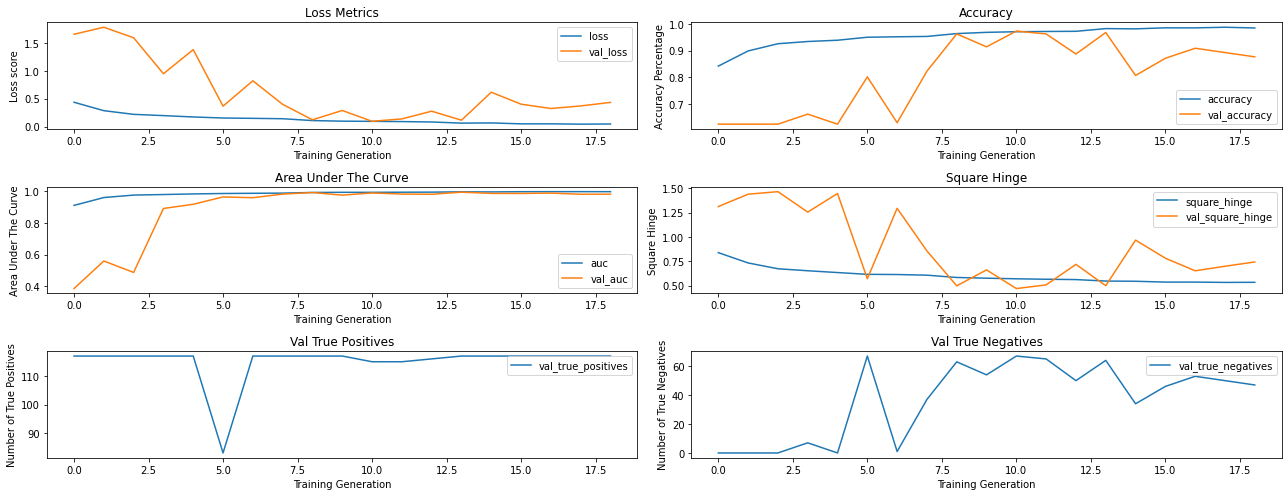

,0.0,1.0,accuracy,macro avg,weighted avg
precision,1.000000,0.670762,0.693364,0.835381,0.794320
recall,0.182927,1.000000,0.693364,0.591463,0.693364
f1-score,0.309278,0.802941,0.693364,0.556110,0.617676
support,164.000000,273.000000,0.693364,437.000000,437.000000


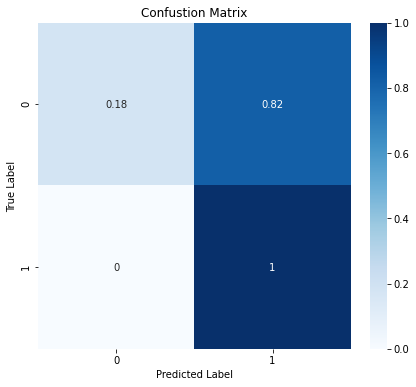

In [ ]:
# This cell runs the fitting 
fourthModelHistory,params = create_model_visuals(
    model = fourthModel, 
    trainGenerator=train, 
    valGenerator=val, 
    testGenerator = test, 
    epochs = 100, 
    batch_size=64,
    class_weight = {0:1, 1:1},
    kwargs = {
        'validation_data': (valImages, valImageLabels),
        'callbacks':[fourthModelCheckpoint, fourthModelEarlyStop, fourthModelLRAdjust]}
        )

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/flatiron school/fourth_model_non_checkpoint/assets
INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/flatiron school/fourth_model_checkpoint/assets


,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.960000,0.858974,0.887872,0.909487,0.896888
recall,0.731707,0.981685,0.887872,0.856696,0.887872
f1-score,0.830450,0.916239,0.887872,0.873345,0.884044
support,164.000000,273.000000,0.887872,437.000000,437.000000


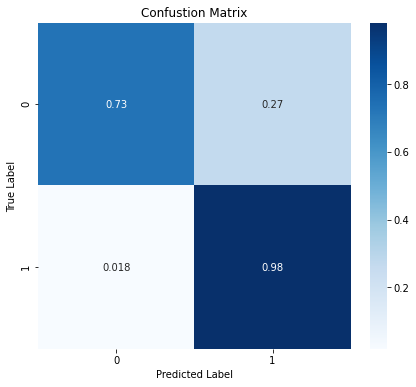

In [ ]:
# The previous fitting method saves the model with the least validation loss score, but also prints out
# the model when the early stopping callback stops the fitting. Because of this we get two models from the previous cell

# save the model spit out by the fit method
keras.models.save_model(fourthModel, 'drive/MyDrive/Colab Notebooks/flatiron school/fourth_model_non_checkpoint/')
#load the model saved by the checkpoint callback
fourthModel = keras.models.load_model('fourth_model/')
#show the eval metrics for the check pointed model
keras.models.save_model(fourthModel, 'drive/MyDrive/Colab Notebooks/flatiron school/fourth_model_checkpoint/')

fourthModel = keras.models.load_model('drive/MyDrive/Colab Notebooks/flatiron school/fourth_model_checkpoint/')
fourthModelHistory,params = create_model_visuals(
    model = fourthModel, 
    trainGenerator=train, 
    valGenerator=val, 
    testGenerator=test, 
    epochs = 100, 
    batch_size=64,
    class_weight = scale_weight(1.5),
    train = False,
    kwargs = {
        'validation_data': (valImages, valImageLabels),
        'callbacks':[fourthModelCheckpoint, fourthModelEarlyStop]})

# Third Party Benchmark
So we've gone through the trouble of creating a model but what does this mean in the grand scheme of things. Is the model good enough to compete in the data science industry? Are there other existing models that can vastly out perform what we've created?

In this case we can take these open ended questions and get some reasonable answer to them. Keras and several other popular neural network modules offer some pre-trained models whose architectures led them to victory in recent global challenges. One such architecture specifically trained on images is the VGG19 network. At this point we are going to load in this original model and play around with it as a more robust comparison of how our model is preforming within the industry. 

This process has several built in options. The model can come with all the layers from start to finish including both convulutional and fully connected layers already trained. There's also options to take only the connvulutional section pre-trained or to import the model architecture without any pre-training whatsoever. In this case, we will take the connvulutional layers having already been pre-trained as re-training them will take too long without considerable computing reasorces. We will create our own dense layers to add ot this model which will taylor the connvulutional layers for our specific task of classifying x-rays. While it seems odd to take a pre-trained state of the art model and add our own layers to it, because the underlying convulutional models are trained on a hugh variety of images, we need a fully connected architecture that will take the vast knowledge contained in the convulutional layers and funnel it down in a way that maximized our classification task. Unfortuneately, there's currently not a fantastic general structure that succeeds at any given task so there will be some trial and error. 

In [ ]:
from keras.applications import VGG19
cnn_base = VGG19(weights='imagenet', 
                 include_top=False, 
                 input_shape=(256, 256, 3))

In [ ]:
benchmarkModel = Sequential()

benchmarkModel.add(cnn_base)

benchmarkModel.add(layers.BatchNormalization())
 
benchmarkModel.add(layers.GlobalAveragePooling2D())
 
benchmarkModel.add(layers.Dense(
    128, 
    kernel_initializer=keras.initializers.Orthogonal(),
    activity_regularizer = keras.regularizers.L2(.03),
    )
)
 
benchmarkModel.add(layers.BatchNormalization())
 
benchmarkModel.add(layers.Dense(
    6,
    activation= 'tanh',
    kernel_initializer = keras.initializers.Orthogonal())
)
 
benchmarkModel.add(layers.BatchNormalization())
 
benchmarkModel.add(layers.Dense(
    6, 
    activation= 'tanh',
    kernel_initializer = keras.initializers.Orthogonal(),
    ))
 
benchmarkModel.add(layers.Dense(1, activation = 'sigmoid'))
 
benchmarkModel.compile(
    optimizer = keras.optimizers.RMSprop(
        learning_rate=.001,
        rho = .9,),
    loss = keras.losses.BinaryCrossentropy(),
    metrics = [
      keras.metrics.BinaryAccuracy(name = 'accuracy'),
      keras.metrics.AUC(name = 'auc'),
      keras.metrics.SquaredHinge(name = 'square_hinge'),
      keras.metrics.TruePositives(name='true_positives'), 
      keras.metrics.TrueNegatives(name = 'true_negatives')]
)


# we define the filepath where any results will be saved
benchmarkModel_filepath = os.path.join('benchmark_model')

# the Callbacks
benchmarkModelEarlyStop = EarlyStopping(patience= 7, mode = 'auto', restore_best_weights=False, monitor='val_loss')
benchmarkModelCheckpoint = ModelCheckpoint(benchmarkModel_filepath,save_best_only=True, monitor='val_loss')
benchmarkModelLRAdjust = ReduceLROnPlateau(monitor = 'val_loss', factor = .5, patience=2, min_delta=.00000000001)

cnn_base.trainable = False
benchmarkModel.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
batch_normalization_18 (Batc (None, 8, 8, 512)         2048      
_________________________________________________________________
global_average_pooling2d_6 ( (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)               65664     
_________________________________________________________________
batch_normalization_19 (Batc (None, 128)               512       
_________________________________________________________________
dense_27 (Dense)             (None, 6)                 774       
_________________________________________________________________
batch_normalization_20 (Batc (None, 6)                

Epoch 1/150
82/82 [==============================] - 65s 793ms/step - loss: 0.3255 - accuracy: 0.8790 - auc: 0.9692 - square_hinge: 0.4672 - true_positives: 3272.0000 - true_negatives: 1313.0000 - val_loss: 2.6529 - val_accuracy: 0.3743 - val_auc: 0.9547 - val_square_hinge: 0.9477 - val_true_positives: 0.0000e+00 - val_true_negatives: 70.0000
Epoch 2/150
82/82 [==============================] - 65s 793ms/step - loss: 0.2080 - accuracy: 0.9151 - auc: 0.9773 - square_hinge: 0.3800 - true_positives: 3479.0000 - true_negatives: 1294.0000 - val_loss: 1.1072 - val_accuracy: 0.3743 - val_auc: 0.9853 - val_square_hinge: 0.8485 - val_true_positives: 0.0000e+00 - val_true_negatives: 70.0000
Epoch 3/150
82/82 [==============================] - 64s 782ms/step - loss: 0.1786 - accuracy: 0.9285 - auc: 0.9809 - square_hinge: 0.3609 - true_positives: 3549.0000 - true_negatives: 1294.0000 - val_loss: 0.5167 - val_accuracy: 0.8930 - val_auc: 0.9835 - val_square_hinge: 0.7653 - val_true_positives: 97.000

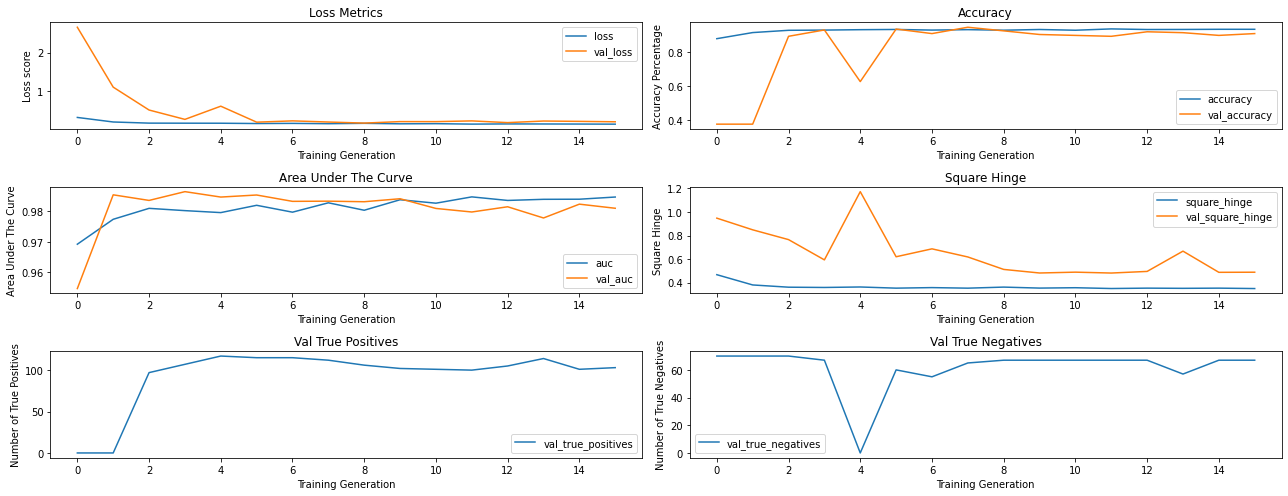

,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.779310,0.825342,0.810069,0.802326,0.808067
recall,0.689024,0.882784,0.810069,0.785904,0.810069
f1-score,0.731392,0.853097,0.810069,0.792244,0.807423
support,164.000000,273.000000,0.810069,437.000000,437.000000


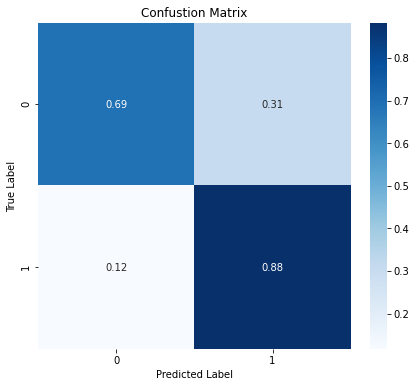

In [ ]:
# This cell runs the fitting 
benchmarkModelHistory,params = create_model_visuals(
    model = benchmarkModel, 
    trainGenerator=train, 
    valGenerator=val, 
    testGenerator=test, 
    epochs = 150, 
    batch_size=64,
    class_weight = scale_weight(1),
    kwargs = {
        'validation_data': (valImages, valImageLabels),
        'callbacks':[benchmarkModelCheckpoint, benchmarkModelEarlyStop, benchmarkModelLRAdjust]})

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/flatiron school/benchmark_model_non_checkpoint/assets
INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/flatiron school/benchmark_model_checkpoint/assets


,0.0,1.0,accuracy,macro avg,weighted avg
precision,0.838983,0.796238,0.80778,0.817611,0.812280
recall,0.603659,0.930403,0.80778,0.767031,0.807780
f1-score,0.702128,0.858108,0.80778,0.780118,0.799571
support,164.000000,273.000000,0.80778,437.000000,437.000000


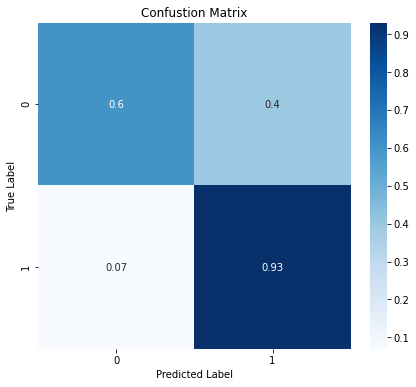

In [ ]:
# The previous fitting method saves the model with the least validation loss score, but also prints out
# the model when the early stopping callback stops the fitting. Because of this we get two models from the previous cell

# save the model spit out by the fit method
keras.models.save_model(benchmarkModel, 'drive/MyDrive/Colab Notebooks/flatiron school/benchmark_model_non_checkpoint/')
#load the model saved by the checkpoint callback
benchmarkModel = keras.models.load_model('benchmark_model/')
#show the eval metrics for the check pointed model
keras.models.save_model(benchmarkModel, 'drive/MyDrive/Colab Notebooks/flatiron school/benchmark_model_checkpoint/')

benchmarkModel = keras.models.load_model('drive/MyDrive/Colab Notebooks/flatiron school/benchmark_model_checkpoint/')
benchmarkModelHistory,params = create_model_visuals(
    model = benchmarkModel, 
    trainGenerator=train, 
    valGenerator=val, 
    testGenerator=test, 
    epochs = 100, 
    batch_size=64,
    class_weight = scale_weight(1),
    train = False,
    kwargs = {
        'validation_data': (valImages, valImageLabels),
        'callbacks':[benchmarkModelCheckpoint, benchmarkModelEarlyStop]})

# Experimental Modles
This section contains various modeling structures which were considered but ultimately not chosen. They are included here just for reference.

## Residual Net

In [ ]:
inputs = Input(shape = (128,128,3), name = 'input_layer')
x = layers.Conv2D(20,kernel_size = (3,3),padding = 'same', strides=1, activation = 'relu')(inputs)
x = layers.BatchNormalization(axis = 3, scale = False)(x)
x = layers.LeakyReLU(.3)(x)

resid1 = layers.Conv2D(20,kernel_size = (3,3),padding = 'same', strides = 2)(x)
x = layers.BatchNormalization(axis = 3, scale = False)(resid1)
x = layers.LeakyReLU(.3)(resid1)
x = layers.Conv2D(20,kernel_size = (3,3),padding = 'same', strides = 1, kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(axis = 3, scale = False)(x)
x = layers.LeakyReLU(.3)(x)
x = layers.Conv2D(20,kernel_size = (3,3),padding = 'same', strides=1)(x)
x = layers.BatchNormalization(axis = 3, scale = False)(x)
x = layers.LeakyReLU(.3)(x)

block1 = layers.add([resid1,x])
resid2 = layers.Conv2D(20,kernel_size = (3,3),padding = 'same', strides = 2, kernel_regularizer = 'l2')(block1)
x = layers.BatchNormalization(axis = 3, scale = False)(resid2)
x = layers.LeakyReLU(.3)(x)
x = layers.Conv2D(20,kernel_size = (3,3),padding = 'same',strides = 1, kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(axis = 3, scale = False)(x)
x = layers.LeakyReLU(.3)(x)

block2 = layers.add([x, resid2])
resid3 = layers.Conv2D(20,kernel_size = (3,3),padding = 'same',strides = 2)(block2)
x = layers.BatchNormalization(axis = 3, scale = False)(resid3)
x = layers.LeakyReLU(.3)(resid3)
x = layers.Conv2D(20,kernel_size = (3,3),padding = 'same',strides = 1)(x)
x = layers.BatchNormalization(axis = 3, scale = False)(x)
x = layers.LeakyReLU(.3)(x)

block3 = layers.add([x, resid3])
resid4 = layers.Conv2D(20,kernel_size = (3,3),padding = 'same',strides = 2)(block3)
x = layers.BatchNormalization(axis = 3, scale = False)(resid4)
x = layers.LeakyReLU(.3)(resid4)
x = layers.Conv2D(20,kernel_size = (3,3),padding = 'same',strides = 1)(x)
x = layers.BatchNormalization(axis = 3, scale = False)(x)
x = layers.LeakyReLU(.3)(x)

block4 = layers.add([x, resid4])
resid5 = layers.Conv2D(20,kernel_size = (3,3),padding = 'same',strides = 2)(block4)
x = layers.BatchNormalization(axis = 3, scale = False)(resid5)
x = layers.LeakyReLU(.3)(resid5)
x = layers.Conv2D(20,kernel_size = (3,3),padding = 'same',strides = 1)(x)
x = layers.BatchNormalization(axis = 3, scale = False)(x)
x = layers.LeakyReLU(.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation = 'relu')(x)
x = layers.Dense(10, activation = 'relu')(x)
x = layers.Dropout(.3)(x)
x = layers.LeakyReLU()(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)

experimentalModel1 = Model(inputs = inputs, outputs = outputs, name = 'experimental_model_1')
experimentalModel1.summary()

Model: "experimental_model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_218 (Conv2D)             (None, 128, 128, 20) 560         input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization_76 (BatchNo (None, 128, 128, 20) 60          conv2d_218[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 20) 0           batch_normalization_76[0][0]     
_______________________________________________________________________________

In [ ]:
experimentalModel1.compile(
    optimizer =  keras.optimizers.RMSprop(learning_rate=.0001),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
experimental1Model_filepath = os.path.join('exmodel1')
experimental1ModelEarlyStop = EarlyStopping(patience=5, mode = 'auto', restore_best_weights=False)
experimental1ModelCheckpoint = ModelCheckpoint(experimental1Model_filepath,save_best_only=True)

In [ ]:
exHistory = experimentalModel1.fit(
    train,
    epochs=50,
    batch_size=32,
    validation_data=valImagesModel,
    class_weight = scale_weight(1),
    callbacks=[experimental1ModelCheckpoint, experimental1ModelEarlyStop]
)

Epoch 1/50
163/163 [==============================] - 26s 161ms/step - loss: 0.8645 - accuracy: 0.7987 - val_loss: 1.7544 - val_accuracy: 0.6290
Epoch 2/50
163/163 [==============================] - 21s 126ms/step - loss: 0.4898 - accuracy: 0.8907 - val_loss: 2.1108 - val_accuracy: 0.6290
Epoch 3/50
163/163 [==============================] - 26s 159ms/step - loss: 0.3651 - accuracy: 0.9197 - val_loss: 1.6140 - val_accuracy: 0.6290
Epoch 4/50
163/163 [==============================] - 20s 125ms/step - loss: 0.3130 - accuracy: 0.9189 - val_loss: 3.3740 - val_accuracy: 0.6290
Epoch 5/50
163/163 [==============================] - 20s 125ms/step - loss: 0.2815 - accuracy: 0.9191 - val_loss: 2.5323 - val_accuracy: 0.6290
Epoch 6/50
163/163 [==============================] - 20s 126ms/step - loss: 0.2735 - accuracy: 0.9258 - val_loss: 3.2565 - val_accuracy: 0.6290
Epoch 7/50
163/163 [==============================] - 21s 126ms/step - loss: 0.2468 - accuracy: 0.9308 - val_loss: 2.9589 - val_ac

In [ ]:
yex1_hat_train = experimentalModel1.predict(test).round()
yex1_train = test.y
confustion_matrix(yex1_train, yex1_hat_train)

In [ ]:
experimentalModel1.evaluate(testImagesModel)
experimentalModel1.evaluate(valImagesModel)

4/4 [==============================] - 0s 8ms/step - loss: 2.5964 - accuracy: 0.6290


[2.596433639526367, 0.6290322542190552]

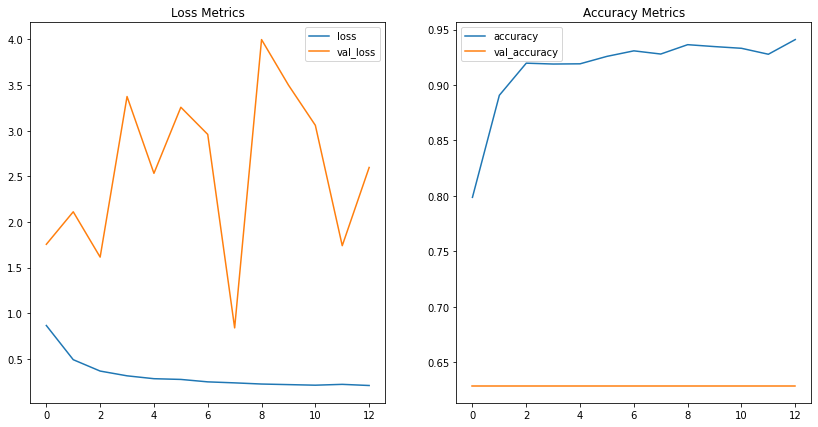

In [ ]:
dfEx1Model = pd.DataFrame.from_dict(exHistory.history)
fig, ((ax1, ax2)) = plt.subplots(nrows = 1,ncols = 2, figsize = (14,7))
dfEx1Model.plot(y = ['loss', 'val_loss'],ax = ax1, title = 'Loss Metrics');
dfEx1Model.plot(y = ['accuracy', 'val_accuracy'],ax = ax2, title = 'Accuracy Metrics');

In [ ]:
experimentalModel1.evaluate(test)

## Multiple Inputs

In [ ]:
inputs = Input(shape = (128,128,1), name = 'input_layer')
x1 = layers.Conv2D(10,kernel_size = (15,15),padding = 'same', strides=1, activation = 'relu')(inputs)
x1 = layers.MaxPool2D(2, padding = 'same')(x1)
x1 = layers.Conv2D(10,kernel_size = (15,15),padding = 'same', strides=1, activation = 'relu')(x1)
x1 = layers.MaxPool2D(2, padding = 'same')(x1)
x1 = layers.Flatten()(x1)
x1 = layers.Dense(10, activation = 'relu')(x1)
x1 = layers.Dense(1, activation = 'sigmoid')(x1)

x2 = layers.Conv2D(10,kernel_size = (11,11),padding = 'same', strides=1, activation = 'relu')(inputs)
x2 = layers.MaxPool2D(2, padding = 'same')(x2)
x2 = layers.Conv2D(10,kernel_size = (11,11),padding = 'same', strides=1, activation = 'relu')(x2)
x2 = layers.MaxPool2D(2, padding = 'same')(x2)
x2 = layers.Flatten()(x2)
x2 = layers.Dense(10, activation = 'relu')(x2)
x2 = layers.Dense(1, activation = 'sigmoid')(x2)

x3 = layers.Conv2D(10,kernel_size = (7,7),padding = 'same', strides=1, activation = 'relu')(inputs)
x3 = layers.MaxPool2D(2, padding = 'same')(x3)
x3 = layers.Conv2D(10,kernel_size = (7,7),padding = 'same', strides=1, activation = 'relu')(x3)
x3 = layers.MaxPool2D(2, padding = 'same')(x3)
x3 = layers.Flatten()(x3)
x3 = layers.Dense(10, activation = 'relu')(x3)
x3 = layers.Dense(1, activation = 'sigmoid')(x3)

x4 = layers.Conv2D(10,kernel_size = (3,3),padding = 'same', strides=1, activation = 'relu')(inputs)
x4 = layers.MaxPool2D(2, padding = 'same')(x4)
x4 = layers.Conv2D(10,kernel_size = (3,3),padding = 'same', strides=1, activation = 'relu')(x4)
x4 = layers.MaxPool2D(2, padding = 'same')(x4)
x4 = layers.Flatten()(x4)
x4 = layers.Dense(10, activation = 'relu')(x4)
x4 = layers.Dense(1, activation = 'sigmoid')(x4)


block1 = layers.add([x1, x2, x3, x4])

# x = layers.MaxPool2D(2, padding = 'same')(block1)
# x = layers.Conv2D(10, kernel_size = (3,3),padding = 'same', strides=1, activation = 'relu')(x)
# x = layers.MaxPool2D(2, padding = 'same')(x)
# x = layers.Flatten()(x)
x = layers.Dense(100, activation = 'relu')(block1)
x = layers.Dropout(.3)(x)
x = layers.Dense(10, activation - 'relu')(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)

experimentalModel2 = Model(inputs = inputs, outputs = outputs, name = 'experimental_model_1')
experimentalModel2.summary()

In [ ]:
experimentalModel2.compile(
    optimizer =  'rmsprop',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
experimental2Model_filepath = os.path.join('exmodel2')
experimental2ModelEarlyStop = EarlyStopping(patience=5, mode = 'auto', restore_best_weights=False)
experimental2ModelCheckpoint = ModelCheckpoint(experimental2Model_filepath,save_best_only=True)

In [ ]:
exHistory = experimentalModel2.fit(
    alteredTrainImage,
    epochs=50,
    batch_size=32,
    validation_data=valImageModel,
    class_weight = {0:weights[0], 1:weights[1]},
    callbacks=[experimental2ModelCheckpoint, experimental2ModelEarlyStop]
)

## Experimental 3

In [ ]:
inputs = Input(shape = (128,128,1), name = 'input_layer')
x1 = layers.Conv2D(10,kernel_size = (15,15),padding = 'same', strides=1, activation = 'relu')(inputs)
x1 = layers.MaxPool2D(2, padding = 'same')(x1)

x2 = layers.Conv2D(10,kernel_size = (11,11),padding = 'same', strides=1, activation = 'relu')(inputs)
x2 = layers.MaxPool2D(2, padding = 'same')(x2)

x3 = layers.Conv2D(10,kernel_size = (7,7),padding = 'same', strides=1, activation = 'relu')(inputs)
x3 = layers.MaxPool2D(2, padding = 'same')(x3)

x4 = layers.Conv2D(10,kernel_size = (3,3),padding = 'same', strides=1, activation = 'relu')(inputs)
x4 = layers.MaxPool2D(2, padding = 'same')(x4)

block1 = layers.add([x1, x2, x3, x4])

x1 = layers.Conv2D(10,kernel_size = (15,15),padding = 'same', strides=1, activation = 'relu')(block1)
x1 = layers.MaxPool2D(2, padding = 'same')(x1)


x2 = layers.Conv2D(10,kernel_size = (11,11),padding = 'same', strides=1, activation = 'relu')(block1)
x2 = layers.MaxPool2D(2, padding = 'same')(x2)


x3 = layers.Conv2D(10,kernel_size = (7,7),padding = 'same', strides=1, activation = 'relu')(block1)
x3 = layers.MaxPool2D(2, padding = 'same')(x3)


x4 = layers.Conv2D(10,kernel_size = (3,3),padding = 'same', strides=1, activation = 'relu')(block1)
x4 = layers.MaxPool2D(2, padding = 'same')(x4)

block2 = layers.add([x1, x2, x3, x4])
x = layers.Flatten()(block2)
x = layers.Dense(10, activation = 'relu')(x)
outputs = layers.Dense(1, activation = 'sigmoid')(x)

experimentalModel3 = Model(inputs = inputs, outputs = outputs, name = 'experimental_model_1')
experimentalModel3.summary()

Model: "experimental_model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_200 (Conv2D)             (None, 128, 128, 10) 2260        input_layer[0][0]                
__________________________________________________________________________________________________
conv2d_201 (Conv2D)             (None, 128, 128, 10) 1220        input_layer[0][0]                
__________________________________________________________________________________________________
conv2d_202 (Conv2D)             (None, 128, 128, 10) 500         input_layer[0][0]                
_______________________________________________________________________________

In [ ]:
experimentalModel3.compile(
    optimizer =  'rmsprop',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
experimental3Model_filepath = os.path.join('exmodel3')
experimental3ModelEarlyStop = EarlyStopping(patience=9, mode = 'auto', restore_best_weights=True)
experimental3ModelCheckpoint = ModelCheckpoint(experimental3Model_filepath,save_best_only=True)

In [ ]:
ex3History = experimentalModel3.fit(
    train,
    epochs=50,
    batch_size=32,
    validation_data=val,
    class_weight = {0:weights[0], 1:weights[1]},
    callbacks=[experimental3ModelCheckpoint, experimental3ModelEarlyStop]
)

Epoch 1/50
163/163 [==============================] - 241s 1s/step - loss: 0.8237 - accuracy: 0.6286 - val_loss: 0.7336 - val_accuracy: 0.5726
Epoch 2/50
163/163 [==============================] - 241s 1s/step - loss: 0.5895 - accuracy: 0.7412 - val_loss: 0.6435 - val_accuracy: 0.5806
Epoch 3/50
163/163 [==============================] - 243s 1s/step - loss: 0.5254 - accuracy: 0.7745 - val_loss: 0.6156 - val_accuracy: 0.7016
Epoch 4/50
163/163 [==============================] - 242s 1s/step - loss: 0.6814 - accuracy: 0.8016 - val_loss: 0.7182 - val_accuracy: 0.6210
Epoch 5/50
163/163 [==============================] - 244s 1s/step - loss: 0.4926 - accuracy: 0.7947 - val_loss: 0.4853 - val_accuracy: 0.7984
Epoch 6/50
163/163 [==============================] - 241s 1s/step - loss: 0.4907 - accuracy: 0.8083 - val_loss: 0.5871 - val_accuracy: 0.7177
Epoch 7/50
163/163 [==============================] - 241s 1s/step - loss: 0.4642 - accuracy: 0.8025 - val_loss: 0.5376 - val_accuracy: 0.7258

KeyboardInterrupt: 

# Visualizing our model's activations
Neural networks are vague by their very nature. Begin at a random point and optimize a buch of weights until we've reached a local loss function minimum. Trying to explain this process for image recognition with an explanation of the underlying process is inherantly flawed. When you see an image of your friends, can you describe how your brain was able to translate a bunch of pixel data into an understanding of the person those pixels are depicting? The answer (unless you've recently made some impressive breakthroughs in neural science) is no. CNNs are much the same. A much more useful way to get an understanding of what's going on is to break images down into features that can intuitively be assembled together to create understanding. The following cells contain images which depict what the neural network was "seeing" at various parts of the learning process.

<img src = "https://drive.google.com/uc?id=1pes1jqx7k8l7D4g2MVYMX6nUPU_g3wwz">

In [ ]:
# finalModel = keras.models.load_model('drive/MyDrive/Colab Notebooks/flatiron school/second_model_94-05_recall_97/')
# finalModel.summary()

In [ ]:
# Extract model layer outputs
layer_outputs = [layer.output for layer in finalModel.layers[:2]]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = keras.models.Model(inputs=finalModel.input, outputs=layer_outputs)

In [ ]:
activations = activation_model.predict(val[0][0])
# We slice the third channel and preview the results
fig, axes = plt.subplots(4,4, figsize = (16,16))
for i in range(16):
    row = i//4
    column = i%4
    ax = axes[row, column]
    first_layer_activation = activations[0]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')
plt.show()

# Business Insights and Conclusions
### Was the Project a Success?
In short, yes!
### Recommendations
#### 1. Medical Triage:
With an apperant ability to classify patients with Pneumonia 97% of the time, the model can be an effective triage mechanism for both emergancy and non-emergancy cases. The model should be integrated into the medical imaging work flow and predictions should be rendered at the time patient gets the image taken. These predictions can be used to prioritize patients the model sees as having pneumonia by flagging their charts as likely positive cases. Combining this knowledge with individual patient health knowledge can be used to prioritize patients at higher risk if treatment isn't rendered quickly. 

#### 2. System Redundancy:
Predictive models can serve as a redundant safety and liability measure for radiologists. Radiologist preformace is not perfect. While mistakes happen for a variety of reasons, there is little in the way of arguing they are necessary for the industry. Having a model that predicts pneumonia with a high degree of accuracy offers an additional safety net for against mis-diagnoses as the probability that both the model and the radiologist are wrong is less likely than either of them getting a prediction wrong. This safety net provides two benefits to the industry. Patients are less likely to be caused harm due to a mis-diagnoses, a clear win. Also, as the world of radiology is plagued with malpractice suits for failiar to diagnose something on a diagnostic image, the model will offer an additional insurance against a mis-diagnosis. 

#### 3. Record Conflicting Predictions:
Neural Networks can be greatly improved with increasing edge case detection. Edge cases are the difficult example which are routinely predicted incorrectly across architectures. If this model is integrated into the medical workflow, there will be examples in which the radiologist and the model have opposite predictions. These cases should be saved and specially catalouged as they are a reasonable standard for an edge case. Knowning difficult examples can be a huge advantage to a neural network as models allow for specific tuning to give edge cases more weight. These cases can be re-trained on and will greatly increase the model's effectiveness at correctly predicting the hard cases benefitting both medical science - by perhaps giving insight in the why the classification was difficult - and patient health. 
    
## Project Summary
Success with a graduated task is often in the eyes of the beholder. Is the final model produced here the absolute best model in the world. No. Does it rank in the top 100 models? Also, probably no. Would the model be a genuine benefit to a workflow in the medical industry that currently lacks AI technology? Absolutely. The ability to capture 97% of pnumonia patients based on a chest x-ray is pretty incredible considering a study published in the National Center for Biotechnology Informations journal found in a study that among various groups of radiologists the best average achieved by any category was just under 86% [1]. Granted, the study involved a blind assessment of an x-ray for all possible conditions and not a binary classification. Still, despite the comparison not being entirely fair, the model does appear to be preforming admirably. 

If considering the model to be roughly as good as a radiologist at diagnosing pnuemonia specifically, then our model offers a competant second opinion in a faction of the time and - if configured correctly in software - available at the time of the x-ray it self and not days later. A decision by the model and a subsequent radiologist are certainly not independent events but it stands to reason that the probability of both predictors incorrectly identifiying a patients diagnosis is lower than each individually (probably close to 0). To summarize, the model offers significant benefits in terms of being able to diagnose patients sick with pnuenomia 97% of the time. Combine this an immediate classification triage and a second round check for the eventual radiologist review, and this model's worth would be measured in lives saved.


# Deployment
The best model in this project has been deployed as a useable endpoint at [https://mod4-dash.herokuapp.com/](https://)

# Future Work
## 1. Additional image augmentation and sampling techniquies
   The fourth model's performace was underwhelming. In general more data should almost always lead to better neural network performace. In the case of the fourth model, we observed a slight decrease in performace when compared to the second model. Further investigation is needed to determine why this was the case. Because we used augmented data there is a possibility the model is recognizing the augmented images as belonging to the originals data set. Changing more of the data augmentation parameters should tease out what is happening. 
    

## 2. Non-Sequential Modeling

   Keras has an additional AIP called the "functional API" which allows for non-sequntial architectures. This feature has many more possibilities for creating effective model architectures including short circuit paths for layer perssistnace as well as spliting and joining modeling pipelines. 

# References
1. Assessing the accuracy and certainty in interpreting chest X-rays in the medical division
I Satia, S Bashagha, A Bibi, R Ahmed, S Mellor, F Zaman
Clin Med (Lond) 2013 Aug; 13(4): 349–352. doi: 10.7861/clinmedicine.13-4-349
PMCID: PMC4954299